## Sinusoidal gamma generator example
* https://nest-simulator.readthedocs.io/en/latest/auto_examples/sinusoidal_gamma_generator.html

### TOC
* The script is structured into two parts, each of which generates its own figure. 
* In part 1A, two generators are created with different orders of the underlying gamma process and their resulting PST (Peristiumulus time) and ISI (Inter-spike interval) histograms are plotted. 
* Part 1B illustrates the effect of the individual_spike_trains switch. 
* In Part 2, the effects of different settings for rate, phase and frequency are demonstrated.

In [1]:
import matplotlib.pyplot as plt
import nest
import numpy as np

nest.ResetKernel()  # in case we run the script multiple times from iPython


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0-post0.dev0
 Built: Oct  2 2024 11:54:50

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



[admin:1947826] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.admin.1000/jf.0/3041001472/shared_mem_cuda_pool.admin could be created.
[admin:1947826] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


In [2]:
plt.figure()
nest.resolution = 0.01


Oct 10 08:01:18 SimulationManager::set_status [Info]: 
    Temporal resolution changed 

<Figure size 640x480 with 0 Axes>

from 0.1 to 0.01 ms.


In [3]:
num_nodes = 2
g = nest.Create(
    "sinusoidal_gamma_generator",
    n=num_nodes,
    params={"rate": 10000.0, "amplitude": 5000.0, "frequency": 10.0, "phase": 0.0, "order": [2.0, 10.0]},
)  # note the syntax for different order parameter of the two nodes

m = nest.Create("multimeter", num_nodes, {"interval": 0.1, "record_from": ["rate"]})
s = nest.Create("spike_recorder", num_nodes)

nest.Connect(m, g, "one_to_one")
nest.Connect(g, s, "one_to_one")

nest.Simulate(200)


Oct 10 08:01:29 NodeManager::prepare_nodes [Info]: 
    Preparing 6 nodes for simulation.

Oct 10 08:01:29 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 6
    Simulation time (ms): 200
    Number of OpenMP threads: 1
    Number of MPI processes: 1

Oct 10 08:01:29 SimulationManager::run [Info]: 
    Simulation finished.


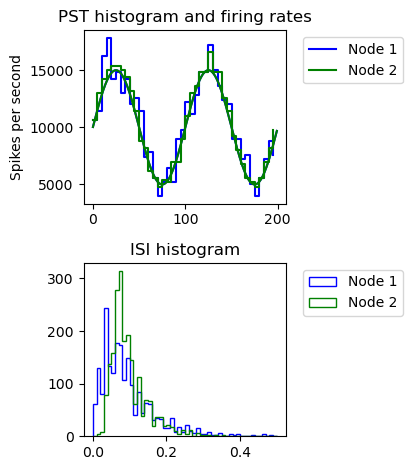

In [19]:
colors = ["b", "g"]

for j in range(num_nodes):
    ev = m[j].events
    t = ev["times"]
    r = ev["rate"]

    spike_times = s[j].events["times"]

    plt.subplot(221)
    h, e = np.histogram(spike_times, bins=np.arange(0.0, 201.0, 5.0))
    plt.plot(t, r, color=colors[j], label=f"Node {j+1}")
    plt.step(e[:-1], h * 1000 / 5.0, color=colors[j], where="post")
    plt.title("PST histogram and firing rates")
    plt.ylabel("Spikes per second")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.subplot(223)
    plt.hist(np.diff(spike_times), bins=np.arange(0.0, 0.505, 0.01), histtype="step", color=colors[j], label=f"Node {j+1}")
    plt.title("ISI histogram")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.tight_layout()

In [22]:
nest.ResetKernel()
nest.local_num_threads = 4


Oct 10 08:06:50 NodeManager::prepare_nodes [Info]: 
    Preparing 28 nodes for simulation.

Oct 10 08:06:50 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 28
    Simulation time (ms): 200
    Number of OpenMP threads: 4
    Number of MPI processes: 1

Oct 10 08:06:50 SimulationManager::run [Info]: 
    Simulation finished.


Text(0.5, 1.0, 'Individual spike trains for each target')

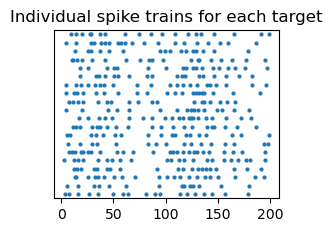

In [23]:
g = nest.Create(
    "sinusoidal_gamma_generator",
    params={
        "rate": 100.0,
        "amplitude": 50.0,
        "frequency": 10.0,
        "phase": 0.0,
        "order": 3.0,
        "individual_spike_trains": True, # this is the only difference to the following example
    },
)
p = nest.Create("parrot_neuron", 20)
s = nest.Create("spike_recorder")

nest.Connect(g, p)
nest.Connect(p, s)

nest.Simulate(200)
ev = s.events
plt.subplot(222)
plt.plot(ev["times"], ev["senders"] - min(ev["senders"]), "o", markersize=2)
plt.ylim([-0.5, 19.5])
plt.yticks([])
plt.title("Individual spike trains for each target")


Oct 10 08:07:10 NodeManager::prepare_nodes [Info]: 
    Preparing 25 nodes for simulation.

Oct 10 08:07:10 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 25
    Simulation time (ms): 200
    Number of OpenMP threads: 4
    Number of MPI processes: 1

Oct 10 08:07:10 SimulationManager::run [Info]: 
    Simulation finished.


Text(0.5, 1.0, 'One spike train for all targets')

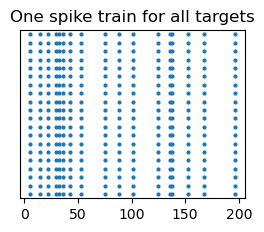

In [24]:
nest.ResetKernel()
nest.local_num_threads = 4

g = nest.Create(
    "sinusoidal_gamma_generator",
    params={
        "rate": 100.0,
        "amplitude": 50.0,
        "frequency": 10.0,
        "phase": 0.0,
        "order": 3.0,
        "individual_spike_trains": False, # this is the only difference to the previous example
    },
)
p = nest.Create("parrot_neuron", 20)
s = nest.Create("spike_recorder")

nest.Connect(g, p)
nest.Connect(p, s)

nest.Simulate(200)
ev = s.events
plt.subplot(224)
plt.plot(ev["times"], ev["senders"] - min(ev["senders"]), "o", markersize=2)
plt.ylim([-0.5, 19.5])
plt.yticks([])
plt.title("One spike train for all targets")

In [25]:
def step(t, n, initial, after, seed=1, dt=0.05):
    nest.ResetKernel()
    nest.resolution = dt
    nest.rng_seed = seed

    g = nest.Create("sinusoidal_gamma_generator", n, params=initial)
    sr = nest.Create("spike_recorder")
    nest.Connect(g, sr)
    nest.Simulate(t / 2)
    g.set(after)
    nest.Simulate(t / 2)

    return sr.events

In [28]:
def plot_hist(spikes):
    plt.hist(spikes["times"], bins=np.arange(0.0, max(spikes["times"]) + 1.5, 1.0), histtype="step")


t = 1000
n = 1000
dt = 1.0
steps = int(t / dt)
offset = t / 1000.0 * 2 * np.pi





Oct 10 08:09:33 correlation_detector [Info]: 
    Default for delta_tau changed from 0.5 to 5 ms

Oct 10 08:09:33 correlomatrix_detector [Info]: 
    Default for delta_tau changed from 0.5 to 5 ms

Oct 10 08:09:33 correlospinmatrix_detector [Info]: 
    Default for delta_tau changed from 0.1 to 1 ms

Oct 10 08:09:33 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 1 ms.

Oct 10 08:09:33 NodeManager::prepare_nodes [Info]: 
    Preparing 1001 nodes for simulation.

Oct 10 08:09:33 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1001
    Simulation time (ms): 500
    Number of OpenMP threads: 1
    Number of MPI processes: 1

Oct 10 08:09:33 SimulationManager::run [Info]: 
    Simulation finished.

Oct 10 08:09:33 NodeManager::prepare_nodes [Info]: 
    Preparing 1001 nodes for simulation.

Oct 10 08:09:33 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 1001
    Simulation time (ms): 500
    Number of OpenMP 

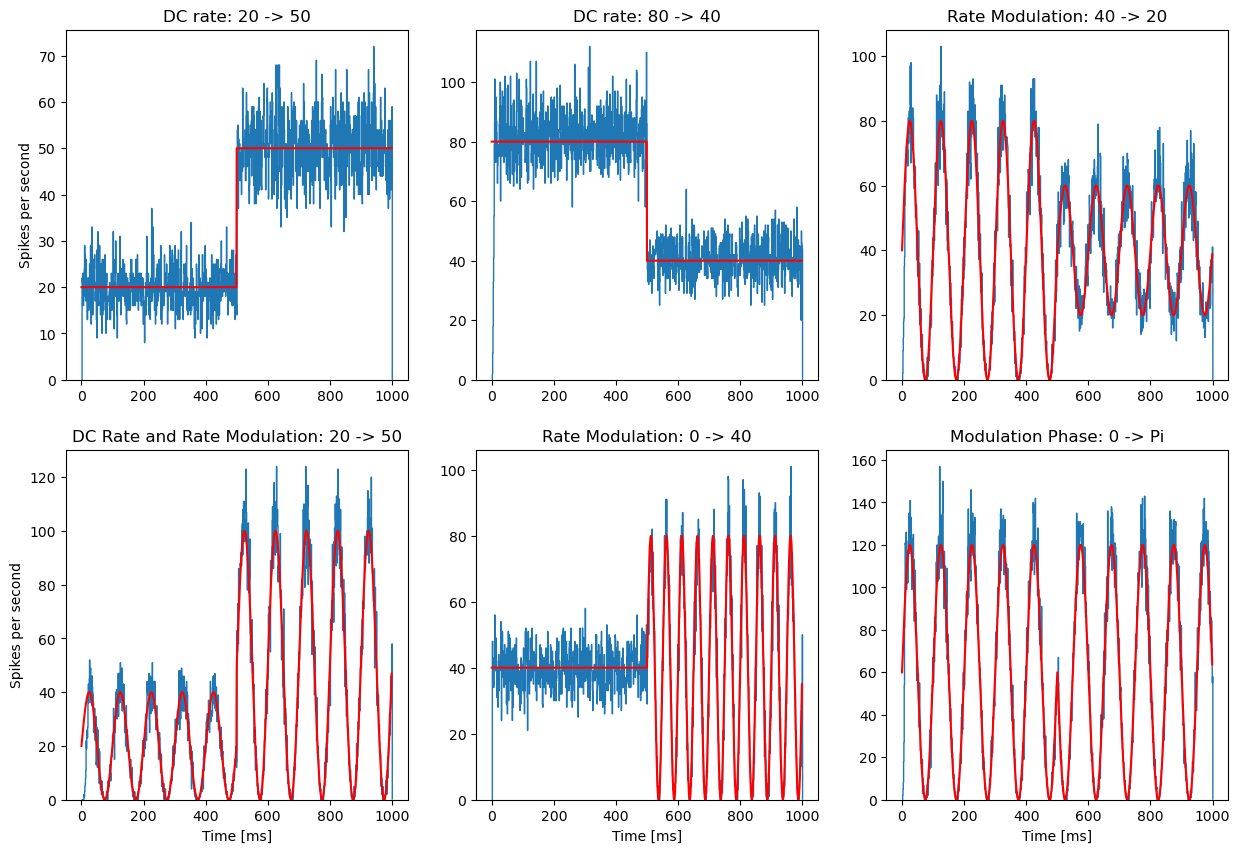

In [34]:
# We create a figure with a 2x3 grid.


grid = (2, 3)
fig = plt.figure(figsize=(15, 10))

plt.subplot(grid[0], grid[1], 1)
spikes = step(
    t,
    n,
    {"rate": 20.0},
    {
        "rate": 50.0,
    },
    seed=123,
    dt=dt,
)
plot_hist(spikes)
exp = np.ones(int(steps))
exp[: int(steps / 2)] *= 20
exp[int(steps / 2) :] *= 50
plt.plot(exp, "r")
plt.title("DC rate: 20 -> 50")
plt.ylabel("Spikes per second")

plt.subplot(grid[0], grid[1], 2)
spikes = step(
    t,
    n,
    {"order": 6.0, "rate": 80.0, "amplitude": 0.0, "frequency": 0.0, "phase": 0.0},
    {"order": 6.0, "rate": 40.0, "amplitude": 0.0, "frequency": 0.0, "phase": 0.0},
    seed=123,
    dt=dt,
)
plot_hist(spikes)
exp = np.ones(int(steps))
exp[: int(steps / 2)] *= 80
exp[int(steps / 2) :] *= 40
plt.plot(exp, "r")
plt.title("DC rate: 80 -> 40")

plt.subplot(grid[0], grid[1], 3)
spikes = step(
    t,
    n,
    {"order": 3.0, "rate": 40.0, "amplitude": 40.0, "frequency": 10.0, "phase": 0.0},
    {"order": 3.0, "rate": 40.0, "amplitude": 20.0, "frequency": 10.0, "phase": 0.0},
    seed=123,
    dt=dt,
)
plot_hist(spikes)
exp = np.zeros(int(steps))
exp[: int(steps / 2)] = 40.0 + 40.0 * np.sin(
    np.arange(0, t / 1000.0 * np.pi * 10, t / 1000.0 * np.pi * 10.0 / (steps / 2))
)
exp[int(steps / 2) :] = 40.0 + 20.0 * np.sin(
    np.arange(0, t / 1000.0 * np.pi * 10, t / 1000.0 * np.pi * 10.0 / (steps / 2)) + offset
)
plt.plot(exp, "r")
plt.title("Rate Modulation: 40 -> 20")


plt.subplot(grid[0], grid[1], 4)
spikes = step(
    t,
    n,
    {"order": 6.0, "rate": 20.0, "amplitude": 20.0, "frequency": 10.0, "phase": 0.0},
    {"order": 6.0, "rate": 50.0, "amplitude": 50.0, "frequency": 10.0, "phase": 0.0},
    seed=123,
    dt=dt,
)
plot_hist(spikes)
exp = np.zeros(int(steps))
exp[: int(steps / 2)] = 20.0 + 20.0 * np.sin(
    np.arange(0, t / 1000.0 * np.pi * 10, t / 1000.0 * np.pi * 10.0 / (steps / 2))
)
exp[int(steps / 2) :] = 50.0 + 50.0 * np.sin(
    np.arange(0, t / 1000.0 * np.pi * 10, t / 1000.0 * np.pi * 10.0 / (steps / 2)) + offset
)
plt.plot(exp, "r")
plt.title("DC Rate and Rate Modulation: 20 -> 50")
plt.ylabel("Spikes per second")
plt.xlabel("Time [ms]")

plt.subplot(grid[0], grid[1], 5)
spikes = step(
    t,
    n,
    {
        "rate": 40.0,
    },
    {"amplitude": 40.0, "frequency": 20.0},
    seed=123,
    dt=1.0,
)
plot_hist(spikes)
exp = np.zeros(int(steps))
exp[: int(steps / 2)] = 40.0 * np.ones(int(steps / 2))
exp[int(steps / 2) :] = 40.0 + 40.0 * np.sin(
    np.arange(0, t / 1000.0 * np.pi * 20, t / 1000.0 * np.pi * 20.0 / (steps / 2))
)
plt.plot(exp, "r")
plt.title("Rate Modulation: 0 -> 40")
plt.xlabel("Time [ms]")

# Phase shift
plt.subplot(grid[0], grid[1], 6)
spikes = step(
    t,
    n,
    {"order": 6.0, "rate": 60.0, "amplitude": 60.0, "frequency": 10.0, "phase": 0.0},
    {"order": 6.0, "rate": 60.0, "amplitude": 60.0, "frequency": 10.0, "phase": 180.0},
    seed=123,
    dt=1.0,
)
plot_hist(spikes)
exp = np.zeros(int(steps))

exp[: int(steps / 2)] = 60.0 + 60.0 * np.sin(
    np.arange(0, t / 1000.0 * np.pi * 10, t / 1000.0 * np.pi * 10.0 / (steps / 2))
)
exp[int(steps / 2) :] = 60.0 + 60.0 * np.sin(
    np.arange(0, t / 1000.0 * np.pi * 10, t / 1000.0 * np.pi * 10.0 / (steps / 2)) + offset + np.pi
)
plt.plot(exp, "r")
plt.title("Modulation Phase: 0 -> Pi")
plt.xlabel("Time [ms]")
plt.show()